In [ ]:
import torch
from datasets_prep.edges2shoes import Edge2Shoes
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

dataset = Edge2Shoes("/Users/Public/Documents/Datasets/edge2shoes", 4, 64, device="cuda:0", split="train")
# 获取一个批次的数据
x, y = dataset[45]
print(x.shape)
print(y.shape)
# 打印图像和标签
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# 显示图像
imshow(x)
imshow(y)

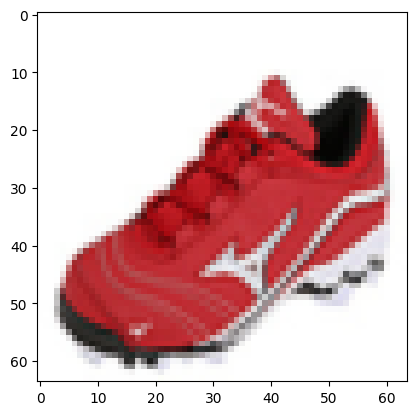

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


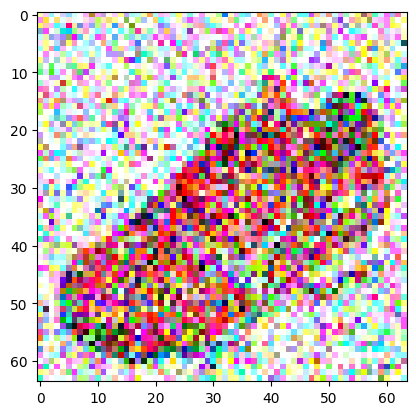

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


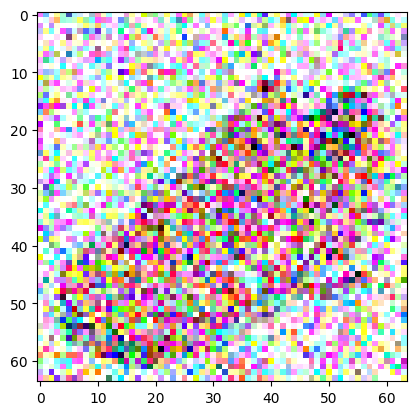

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


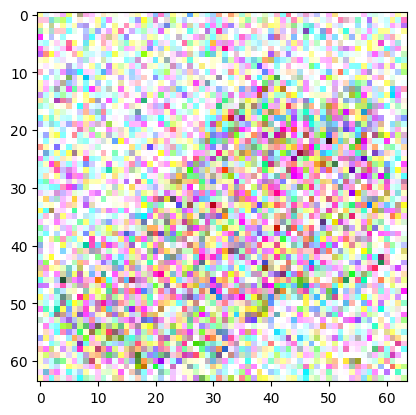

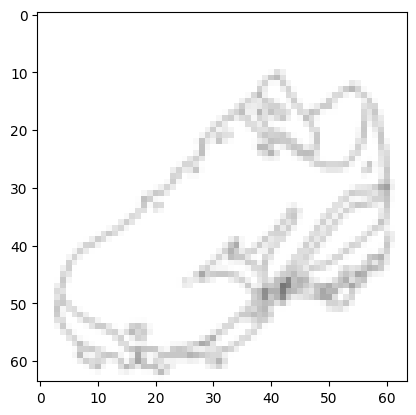

In [11]:
import torchvision.utils as vutils
def q_sample_pairs_for_a_bridge(x_start, t_menus_1, y, T):

    assert y is not None, 'Condition is required for forward diffusion.'
    c_lambda = 2
    t = t_menus_1 + 1
    # print(f"t_menus_1: {t_menus_1}")
    # TODO 移到外面去
    # t = torch.randint(2, T + 1, (batch_size,), device=x_start.device).long() if t is None else t.long()
    t_menus_1 = t_menus_1.unsqueeze(1).unsqueeze(2) # BCWH
    t = t.unsqueeze(1).unsqueeze(2) # BCWH
    m_t_menus_1 = t_menus_1 / T
    # step2 create noise
    noise_xt_menus_1 = torch.randn_like(x_start, device=x_start.device)

    # B_t_menus_1 = c_lambda * (1 - m_t_menus_1) * (torch.log(1 / (1 - m_t_menus_1))) ** 0.5
    B_t_menus_1 = c_lambda * (1 - m_t_menus_1) * (torch.log(1 / (1 - m_t_menus_1))) ** 0.5

    # B_t_menus_1 = torch.where(torch.eq(t_menus_1, T), torch.zeros_like(B_t_menus_1), B_t_menus_1)
    B_t_menus_1 = torch.nan_to_num(B_t_menus_1)

    x_t_menus_1 = (1 - m_t_menus_1) * x_start + m_t_menus_1 * y +  B_t_menus_1 * noise_xt_menus_1
    # x_t_menus_1 = torch.where(torch.eq(m_t_menus_1, 0), x_start, x_t_menus_1)
    # objective = m_t * (y - x_start) + B_t * noise
    noise_x_t = torch.randn_like(x_t_menus_1, device=x_t_menus_1.device)

    x_t_mean = ((T - t) / (T - t + 1)) * x_t_menus_1 + (1 / (T - t + 1)) * y

    x_t_var = c_lambda * (1 - t / T) * torch.sqrt(torch.log((T - t + 1) / (T - t))) 
    # 当t = T 的时候var = 0
    x_t_var = torch.nan_to_num(x_t_var)


    x_t = x_t_mean + x_t_var * noise_x_t

    assert not torch.isnan(B_t_menus_1).any(), "NaN detected in B_t_menus_1"
    assert not torch.isnan(x_t_menus_1).any(), "NaN detected in x_t_menus_1"
    assert not torch.isnan(x_t_mean).any(), "NaN detected in x_t_mean"
    assert not torch.isnan(x_t_var).any(), "NaN detected in x_t_var"
    assert not torch.isnan(x_t).any(), "NaN detected in x_t"
    # print(x_t_menus_1)
    return x_t_menus_1, x_t

device = 'cuda:0'
real_x = x.to(device, non_blocking=True)
real_y = y.to(device, non_blocking=True)
num_timesteps = 4

forward_process = [real_x]
for i in range(0, num_timesteps):
    t_menus_1 = torch.full((real_x.size(0),), i, device=device).long()
    x_t_menus_1, x_t = q_sample_pairs_for_a_bridge(real_x, t_menus_1, real_y, num_timesteps)
    forward_process.append(x_t)

for i in range(len(forward_process)):
    imshow(forward_process[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 64, 64])
torch.Size([3, 3, 64, 64])
torch.Size([3, 3, 64, 64])
torch.Size([3, 3, 64, 64])
torch.Size([3, 3, 64, 64])


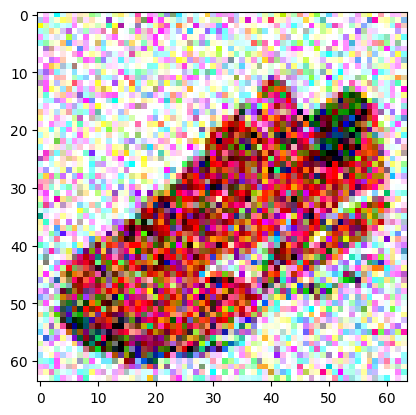

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


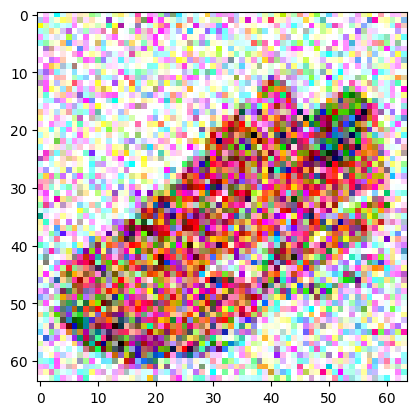

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


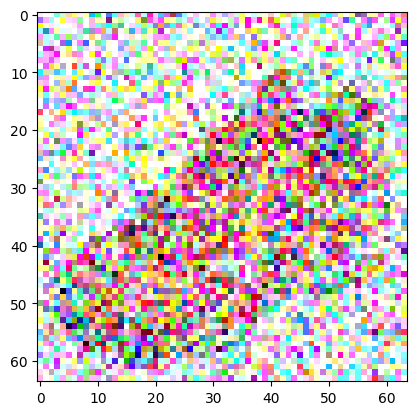

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


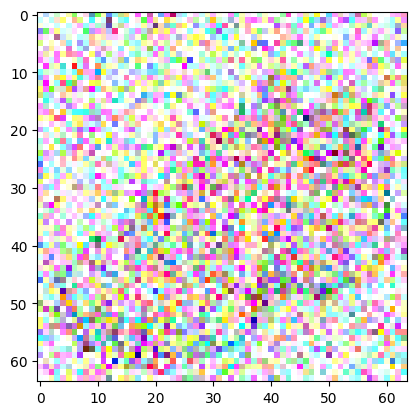

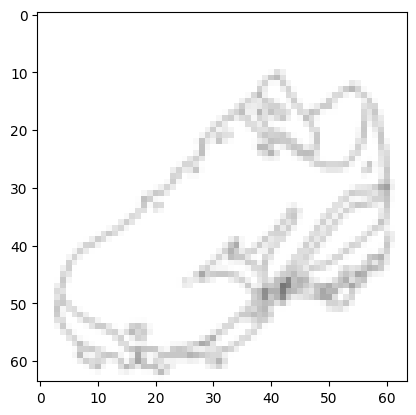

In [15]:
def sample_posterior_A_bridge(x_0, x_t, t_menus_1, y, T):
        
    def q_posterior(x_0, x_t, t, y):
        # print(x_0)
        t = t.unsqueeze(1).unsqueeze(2).unsqueeze(3) # BCWH
        m_t = t / T
        c_lambda = 2
        beta_t = T - t + 1
        gamma_t = torch.log(T / beta_t)
        C = (1 - 1 / beta_t + 1 / (beta_t * gamma_t))
        c_xt = (1 / C * (1 + 1 / (T * gamma_t)))
        c_yt = (1 / C * (1 / beta_t - (t - 1) / (T * beta_t * gamma_t)))
        c_epst = (1 / C * (1 / (T * gamma_t)))
        c_zt = (c_lambda / C * (1 - m_t + 1 / T) ** 0.5 * (1 / T) ** 0.5)
        C = torch.nan_to_num(C)
        c_xt = torch.nan_to_num(c_xt)
        c_yt = torch.nan_to_num(c_yt)
        c_epst = torch.nan_to_num(c_epst)
        c_zt = torch.nan_to_num(c_zt)
        mean = (
            (c_xt - c_epst) * x_t + c_epst * x_0 - c_yt * y
        )
        var = c_zt
        mean = torch.nan_to_num(mean)
        mean = torch.where(t == 1, x_t - (m_t * (y - x_0)), mean)
        var = torch.where(t == 1, torch.zeros_like(var), var)
        return mean, var
    def p_sample(x_0, x_t, t):
        mean, var = q_posterior(x_0, x_t, t, y)
        noise = torch.randn_like(x_t)
        
        x_t_menes_1 = mean + var * noise        
        return x_t_menes_1
    
    sample_x_pos = p_sample(x_0, x_t, t_menus_1 + 1)
    # print(sample_x_pos)
    return sample_x_pos

def sample_from_model_A_bridge(x_0, n_time, x_init, y):
    x = x_init
    x_steps = []
    x_start = x_init.unsqueeze(0)
    x_steps.append(x_start)
    print(x_start.shape)
    with torch.no_grad():
        for i in reversed(range(1 , n_time + 1)):
            t = torch.full((x.size(0),), i, dtype=torch.int64).to(x.device)
            x_new = sample_posterior_A_bridge(x_0, x, t - 1, y, num_timesteps)
            x = x_new.detach()
            x_steps.append(x)
            print(x.shape)
    return x, x_steps

fake_sample, x_steps = sample_from_model_A_bridge(real_x, num_timesteps, real_y, real_y)
# imshow(fake_sample[0])

for i in reversed(range(len(x_steps))):
    imshow(x_steps[i][0])

In [ ]:
# t = torch.full((x.size(0),), 4, dtype=torch.int64).to(real_x.device)
# x_new = sample_posterior_A_bridge(real_x, real_x, t - 1, real_y, num_timesteps)
# # print(x_new.shape)
# imshow(x_new[0])
# # torch.set_printoptions(profile='full')
# print(x_new)